tgb - 5/21/2019 - The general goal of this notebook is to develop the new Jacobian diagnostics to assess the stability of the constrained/not-constrained networks. The sub-goals are:  
1) Developing a Jacobian diagnostics toolbox to normalize the full Jacobian to the right units and analyze the eigenvalues of the dynamical Jacobian  
2) Calculate the Jacobian as a function of latitude in our aquaplanet simulation  
3) Prepare the Jacobian for the collaboration with Noah Brenowitz  

# 1) Jacobian toolbox

## 1.1) Load CBRAIN utilities and a model

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.model_diagnostics import *
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
from numpy import linalg as LA
import matplotlib.pyplot as plt
# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()
TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


In [2]:
coor = xr.open_dataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-01-01-00000.nc",\
                    decode_times=False)
lat = coor.lat; lon = coor.lon;
coor.close();

In [3]:
config_fn = '/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM/pp_config/8col_rad_tbeucler_local_PostProc.yml'
data_fn = '/local/Tom.Beucler/SPCAM_PHYS/8col009_01_valid.nc'
dict_lay = {'SurRadLayer':SurRadLayer,'MassConsLayer':MassConsLayer,'EntConsLayer':EntConsLayer}

In [4]:
NN = {};
%cd $TRAINDIR/HDF5_DATA
# NNA0.01
path = TRAINDIR+'HDF5_DATA/NNA0.01.h5'
NN = load_model(path,custom_objects=dict_lay)
md = ModelDiagnostics(NN,config_fn,data_fn)
NN.summary()

/data/Tom.Beucler/SPCAM_PHYS/HDF5_DATA
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 304)          0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          156160      input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512)          0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)      

## 1.2) Calculate Jacobian for specific soundings

tgb - 5/21/2019 - I have no idea why but the tape must be set to persistent=True and the jacobian to experimental_use_pfor=False to be able to calculate the Jacobian in eager execution mode #magic

In [29]:
itime = 1
X, truth = md.valid_gen[itime]
inp = tf.convert_to_tensor(np.expand_dims(X[0,:],axis=0))

with tf.GradientTape(persistent=True) as tape:
    tape.watch(inp)
    pred = NN(inp)
J = tape.jacobian(pred,inp,experimental_use_pfor=False).numpy()

tgb - 5/21/2019 - Renormalize the Jacobian to 1/(Input units) which does not mean much

In [36]:
JAC = J.squeeze()/md.valid_gen.input_transform.div

In [43]:
JAC

array([[ 5.34224739e+01,  6.49502487e+01,  4.87088770e-01, ...,
        -4.45733895e-04,  1.05961459e-03, -8.24807794e-04],
       [ 1.21442772e+02,  1.22333755e+02, -2.07054844e+01, ...,
        -4.84709512e-04,  1.30157114e-03, -9.32414026e-04],
       [ 1.30711868e+02,  1.33121628e+02,  4.44262695e+01, ...,
        -5.23139257e-04,  1.42412761e-03, -9.37225006e-04],
       ...,
       [ 3.63641680e+04,  3.47609609e+04, -1.61439246e+03, ...,
        -2.30916939e-03,  1.23596467e-01, -9.02039185e-02],
       [-4.73867383e+03,  1.15306677e+03, -4.01582695e+04, ...,
         1.68008276e-03,  1.70316890e-01, -2.05688536e-01],
       [ 1.17274658e+03, -7.65687683e+02, -2.62091797e+04, ...,
         9.70688276e-03, -9.02447253e-02,  1.76221132e-02]], dtype=float32)

In [49]:
dt = 30*60 # Timestep
cf = np.zeros((1, md.valid_gen.n_inputs))
for index in range (md.valid_gen.n_inputs):
    if index<90: cf[0,index]=L_V;
    elif index<120: cf[0,index]=C_P;
    elif index<150: cf[0,index]=1;
    elif index<240: cf[0,index]=L_V*dt;
    elif index<270: cf[0,index]=C_P*dt;
    elif index<301: cf[0,index]=1;
    else: cf[0,index]=dt;

In [50]:
JAC = JAC/cf

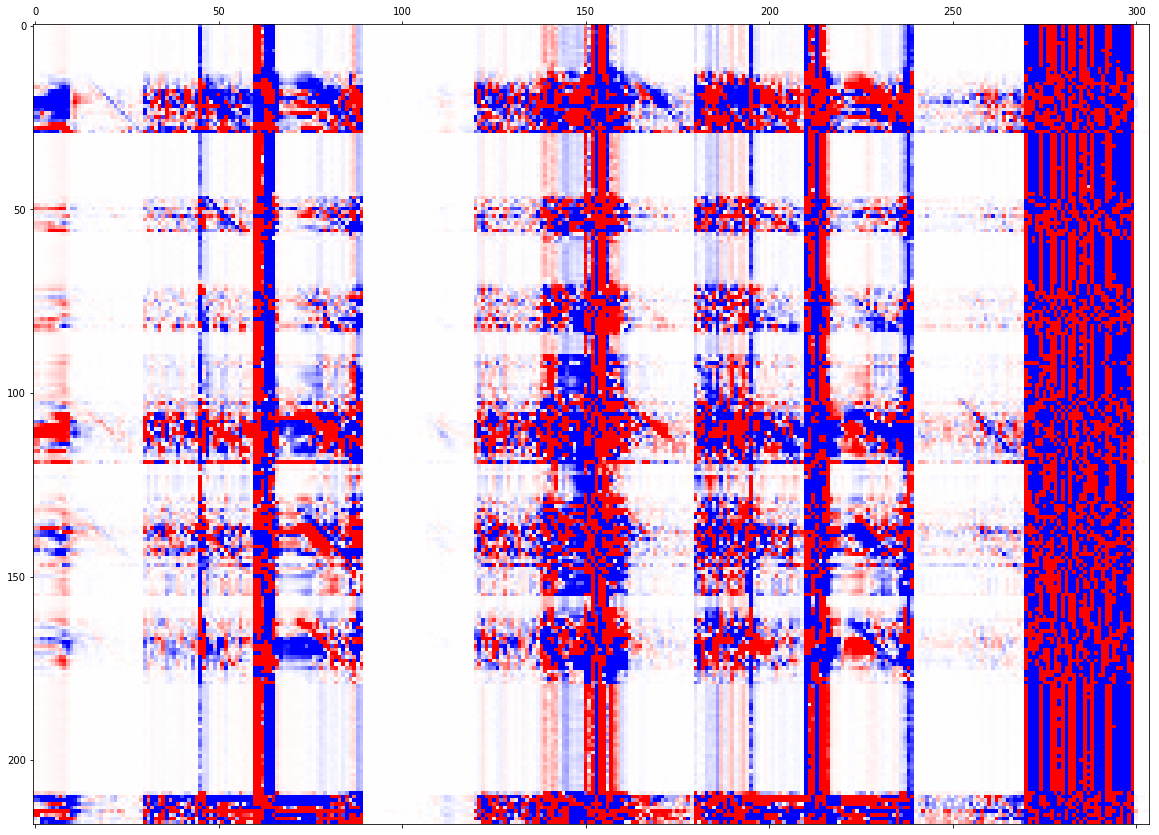

In [51]:
fig, ax = plt.subplots(figsize=(20,20))
ax.matshow(JAC, vmin=-0.01, vmax=0.01, cmap='bwr')

# 1.3) Create corresponding functions

tgb - 5/21/2019 - Following https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/004_Calculating_Jacobians_of_NN_and_dynamics_of_TQ.ipynb but changed the gradient loop to a single Jacobian calculation and made use of the model diagnostics object

In [65]:
def get_TQjacobian(model,inp,sample_index,md):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;

    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs))
    with tf.GradientTape(persistent=True) as tape:
        TFinp = tf.convert_to_tensor(np.expand_dims(inp[0,:],axis=0))
        tape.watch(TFinp)
        pred = NN(TFinp)
    J = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
    .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    JTQ = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JTQ[i,j] = J[i,j] # d(dq/dt)/dq
            elif (i>29) and (j<30): JTQ[i,j] = J[90+(i-30),j]-\
                J[120+(i-30),j]-J[150+(i-30),j] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JTQ[i,j] = J[i,90+(j-30)] # d(dq/dt)/dT
            elif (i>29) and (j>29): JTQ[i,j] = J[90+(i-30),90+(j-30)]-\
                J[120+(i-30),90+(j-30)]-J[150+(i-30),90+(j-30)] # d(dTcon/dt)/dT

    return JTQ

In [66]:
def get_RADjacobian(model,inp,sample_index,md):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;
        
    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs))
    with tf.GradientTape(persistent=True) as tape:
        TFinp = tf.convert_to_tensor(np.expand_dims(inp[0,:],axis=0))
        tape.watch(TFinp)
        pred = NN(TFinp)
    J = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
    .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    JRAD = np.zeros((60,60))
    for i in range (60):
        for j in range(60):
            if (i<30) and (j<30): JRAD[i,j] = J[120+i,j]
            elif (i>29) and (j<30): JRAD[i,j] = J[150+(i-30),j]
            elif (i<30) and (j>29): JRAD[i,j] = J[120+i,90+(j-30)]
            elif (i>29) and (j>29): JRAD[i,j] = J[150+(i-30),90+(j-30)]

    return JRAD

tgb - 5/21/2019 - Get radiative AND convective Jacobian for an entire batch

In [84]:
def get_RADCONjacobian(model,inp,md,ind=np.arange(0,len(inp))):
# model is the neural network model from inp to out
# inp is the input x generator from the generator (object = gen_obj)
# sample_index is the reference number of the sample for x
# md is the model diagnostics object
# ind is the indices over which the Jacobian is calculated
# x.shape = (#sample,#inputs) so we are evaluating the gradient of
# y(sample_index,:) with respect to x(sample_index,:)
# cf is the conversion factor calculated using CAM constants
    cf = np.zeros((1, md.valid_gen.n_inputs))
    for index in range (md.valid_gen.n_inputs):
        if index<90: cf[0,index]=L_V;
        elif index<120: cf[0,index]=C_P;
        elif index<150: cf[0,index]=1;
        elif index<240: cf[0,index]=L_V*DT;
        elif index<270: cf[0,index]=C_P*DT;
        elif index<301: cf[0,index]=1;
    else: cf[0,index]=DT;
    
    JCON = np.zeros((60,60,len(ind)))
    JRAD = np.zeros((60,60,len(ind)))
    
    J = np.zeros((md.valid_gen.n_outputs,md.valid_gen.n_inputs,len(ind)))
    for count,i in enumerate(ind):
        print('i=',i,'/',len(ind)-1,end="\r")
        with tf.GradientTape(persistent=True) as tape:
            TFinp = tf.convert_to_tensor(np.expand_dims(inp[i,:],axis=0))
            tape.watch(TFinp)
            pred = NN(TFinp)
        J[:,:,i] = tape.jacobian(pred,TFinp,experimental_use_pfor=False)\
        .numpy().squeeze()/(cf*md.valid_gen.input_transform.div)
    
    for i in range (60):
        for j in range(60):
            # Convection
            if (i<30) and (j<30): JCON[i,j] = J[i,j,:] # d(dq/dt)/dq
            elif (i>29) and (j<30): JCON[i,j] = J[90+(i-30),j,:]-\
                J[120+(i-30),j,:]-J[150+(i-30),j,:] # d(dTcon/dt)/dq
            elif (i<30) and (j>29): JCON[i,j] = J[i,90+(j-30),:] # d(dq/dt)/dT
            elif (i>29) and (j>29): JCON[i,j] = J[90+(i-30),90+(j-30),:]-\
                J[120+(i-30),90+(j-30),:]-J[150+(i-30),90+(j-30),:] # d(dTcon/dt)/dT
            # Radiation    
            if (i<30) and (j<30): JRAD[i,j,:] = J[120+i,j,:]
            elif (i>29) and (j<30): JRAD[i,j,:] = J[150+(i-30),j,:]
            elif (i<30) and (j>29): JRAD[i,j,:] = J[120+i,90+(j-30),:]
            elif (i>29) and (j>29): JRAD[i,j,:] = J[150+(i-30),90+(j-30),:]

    return JCON,JRAD

In [ ]:
itime = 0
X, truth = md.valid_gen[itime]
JCON,JRAD = get_RADCONjacobian(NN,X,md,np.arange(0,len(X)))

/home/t/Tom.Beucler/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: divide by zero encountered in true_divide


tgb - 5/21/2019 - Save in HDF5 format using https://stackoverflow.com/questions/20928136/input-and-output-numpy-arrays-to-h5py

In [ ]:
import h5py
with h5py.File('HDF5_DATA/014_JCON.h5', 'w') as hf:
    hf.create_dataset("name-of-dataset",  data=JCON)
with h5py.File('HDF5_DATA/014_JRAD.h5', 'w') as hf:
    hf.create_dataset("name-of-dataset",  data=JRAD)

In [94]:
# with h5py.File('HDF5_DATA/014_JCON.h5', 'r') as hf:
#     JREAD = hf['name-of-dataset'][:]

[Text(0, 0, '$\\mathrm{LW_{200hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{500hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{850hPa}}$'),
 Text(0, 0, '$\\mathrm{LW_{967hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{350hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{730hPa}}$'),
 Text(0, 0, '$\\mathrm{SW_{925hPa}}$'),
 Text(0, 0, '')]

<Figure size 1600x1080 with 0 Axes>

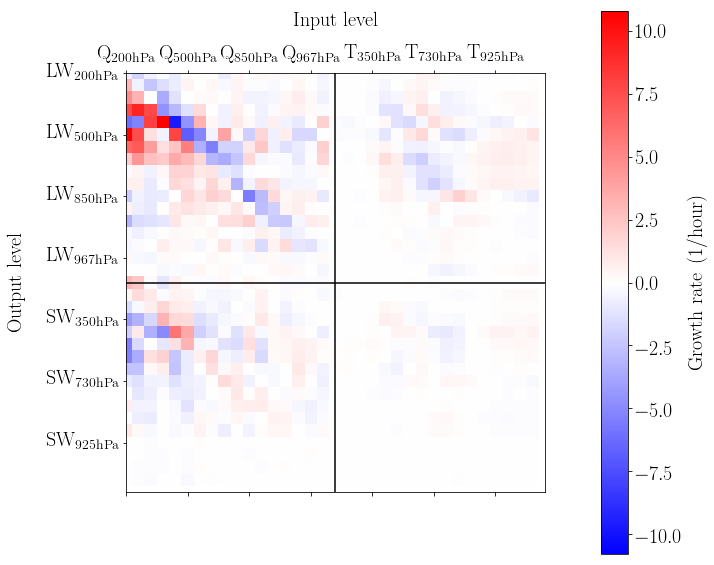

In [88]:
minlev = 200; # Minimum level [hPa]
plot_option = 'RAD'
if plot_option=='RAD': J = JRAD.mean(axis=2)
elif plot_option=='CON': J = JCON.mean(axis=2)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(num=None, figsize=(20, 13.5), dpi=80, facecolor='w', edgecolor='k')

fig, ax = plt.subplots(figsize=(10,10))
# Extract the Jacobian from level minlev to the surface (index 30 here)
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
minind = np.argmin(abs(P-minlev*1e2));
IND = np.concatenate((np.arange(minind,30),np.arange(30+minind,60)),axis=0)
J = J[IND,:]; J = J[:,IND];
cax = ax.matshow(3600*J, vmin=-3600*0.003, vmax=3600*0.003, cmap='bwr')

x = np.linspace(0.,60.,100);
plt.plot(x,J.shape[0]/2*x**0, color='k')
plt.plot(J.shape[0]/2*x**0,x, color='k')

plt.xlim((0,J.shape[0])); plt.ylim((J.shape[0],0))

cbar = fig.colorbar(cax, pad = 0.1)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'$\mathrm{Growth\ rate\ \left(1/hour\right)}$', rotation=90, fontsize = 20)

plt.xticks(fontsize=20); plt.yticks(fontsize=20)
ax.xaxis.set_label_position('top')
X = plt.xlabel(r'Input level', fontsize = 20)
ax.xaxis.labelpad = 20
Y = plt.ylabel(r'Output level', fontsize = 20)
ax.yaxis.labelpad = 20

# fig.canvas.draw()
labelx = [item.get_text() for item in ax.get_xticklabels()]
# labelx[0] = '$\mathrm{QV_{0hPa}}$'
# labelx[1] = '$\mathrm{QV_{130hPa}}$'
# labelx[2] = '$\mathrm{QV_{650hPa}}$'
# labelx[3] = '$\mathrm{T_{0hPa}}$'
# labelx[4] = '$\mathrm{T_{130hPa}}$'
# labelx[5] = '$\mathrm{T_{650hPa}}$'
# labelx[6] = '$\mathrm{T_{1000hPa}}$'
labelx[0] = '$\mathrm{Q_{200hPa}}$'
labelx[1] = '$\mathrm{Q_{500hPa}}$'
labelx[2] = '$\mathrm{Q_{850hPa}}$'
labelx[3] = '$\mathrm{Q_{967hPa}}$'
labelx[4] = '$\mathrm{T_{350hPa}}$'
labelx[5] = '$\mathrm{T_{730hPa}}$'
labelx[6] = '$\mathrm{T_{925hPa}}$'
labely = [item.get_text() for item in ax.get_yticklabels()]
if plot_option=='RAD':
#     labely[0] = '$\mathrm{LW_{0hPa}}$'
#     labely[1] = '$\mathrm{LW_{130hPa}}$'
#     labely[2] = '$\mathrm{LW_{650hPa}}$'
#     labely[3] = '$\mathrm{SW_{0hPa}}$'
#     labely[4] = '$\mathrm{SW_{130hPa}}$'
#     labely[5] = '$\mathrm{SW_{650hPa}}$'
#     labely[6] = '$\mathrm{SW_{1000hPa}}$'
    labely[0] = '$\mathrm{LW_{200hPa}}$'
    labely[1] = '$\mathrm{LW_{500hPa}}$'
    labely[2] = '$\mathrm{LW_{850hPa}}$'
    labely[3] = '$\mathrm{LW_{967hPa}}$'
    labely[4] = '$\mathrm{SW_{350hPa}}$'
    labely[5] = '$\mathrm{SW_{730hPa}}$'
    labely[6] = '$\mathrm{SW_{925hPa}}$'
elif plot_option=='CON':
#     labely[0] = '$\mathrm{\dot{QV}_{0hPa}}$'
#     labely[1] = '$\mathrm{\dot{QV}_{130hPa}}$'
#     labely[2] = '$\mathrm{\dot{QV}_{650hPa}}$'
#     labely[3] = '$\mathrm{\dot{T}_{0hPa}}$'
#     labely[4] = '$\mathrm{\dot{T}_{130hPa}}$'
#     labely[5] = '$\mathrm{\dot{T}_{650hPa}}$'
#     labely[6] = '$\mathrm{\dot{T}_{1000hPa}}$'
    labely[0] = '$\mathrm{\dot{Q}_{200hPa}}$'
    labely[1] = '$\mathrm{\dot{Q}_{500hPa}}$'
    labely[2] = '$\mathrm{\dot{Q}_{850hPa}}$'
    labely[3] = '$\mathrm{\dot{Q}_{967hPa}}$'
    labely[4] = '$\mathrm{\dot{T}_{350hPa}}$'
    labely[5] = '$\mathrm{\dot{T}_{730hPa}}$'
    labely[6] = '$\mathrm{\dot{T}_{925hPa}}$'

ax.set_xticklabels(labelx)
ax.set_yticklabels(labely)